In [1]:
import pymysql
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

N = 100000

In [2]:
db = pymysql.connect(
    host='127.0.0.1', user='kejingfan', 
    password='KJF2811879', database='DBLab_7_2'
)
cursor = db.cursor()

In [3]:
sql_statements = [
    "SET profiling = 1;",
    
    "DROP TABLE IF EXISTS passengers_no_index;",
    "DROP TABLE IF EXISTS passengers_with_index;",
    """
    CREATE TABLE passengers_no_index (
        ID BIGINT PRIMARY KEY,
        `Name` VARCHAR (255) NOT NULL,
        Phone_number BIGINT NOT NULL,
        `Password` VARCHAR (255) NOT NULL,
        CHECK (ID REGEXP '^\\\\d{18}$'),
        CHECK (Phone_number REGEXP '^\\\\d{11}$')
    );
    """,
    """
    CREATE TABLE passengers_with_index (
        ID BIGINT PRIMARY KEY,
        `Name` VARCHAR (255) NOT NULL,
        Phone_number BIGINT NOT NULL,
        `Password` VARCHAR (255) NOT NULL,
        CHECK (ID REGEXP '^\\\\d{18}$'),
        CHECK (Phone_number REGEXP '^\\\\d{11}$')
    );
    """,
    "CREATE INDEX idx_phone_number ON passengers_with_index (Phone_number);",
]

for sql in sql_statements:
    cursor.execute(sql)
db.commit()

In [4]:
id_list = random.sample(range(100000000000000000, 1000000000000000000), N)
phone_number_list = random.sample(range(10000000000, 20000000000), N)

insert_times = {
    'passengers_no_index': [],
    'passengers_with_index': []
}
query_times = {
    'passengers_no_index': [],
    'passengers_with_index': []
}

for table_name in ['passengers_no_index', 'passengers_with_index']:
    print(f"操作数据表 {table_name} ：")
    insert_sql = f'''
        INSERT INTO {table_name} (ID, `Name`, Phone_number, `Password`)
        VALUES (%s, %s, %s, %s);
    '''
    query_sql = f'''
        SELECT * FROM {table_name}
        WHERE Phone_number = %s;
    '''
    
    for i in tqdm(range(N)):
        cursor.execute(insert_sql, (id_list[i], 'kejingfan', phone_number_list[i], 'password'))
        db.commit()
        cursor.execute(query_sql, (phone_number_list[random.randint(0, i)],))
        cursor.execute("SHOW PROFILES;")
        profiles = cursor.fetchall()[-3:]
        profile = profiles[0]
        if "INSERT INTO" in profile[2]:
            insert_times[table_name].append(profile[1])
        profile = profiles[-1]
        if "SELECT * FROM" in profile[2]:
            query_times[table_name].append(profile[1])

cursor.close()
db.close()

操作数据表 passengers_no_index ：


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [20:55<00:00, 79.67it/s]


操作数据表 passengers_with_index ：


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:12<00:00, 126.20it/s]


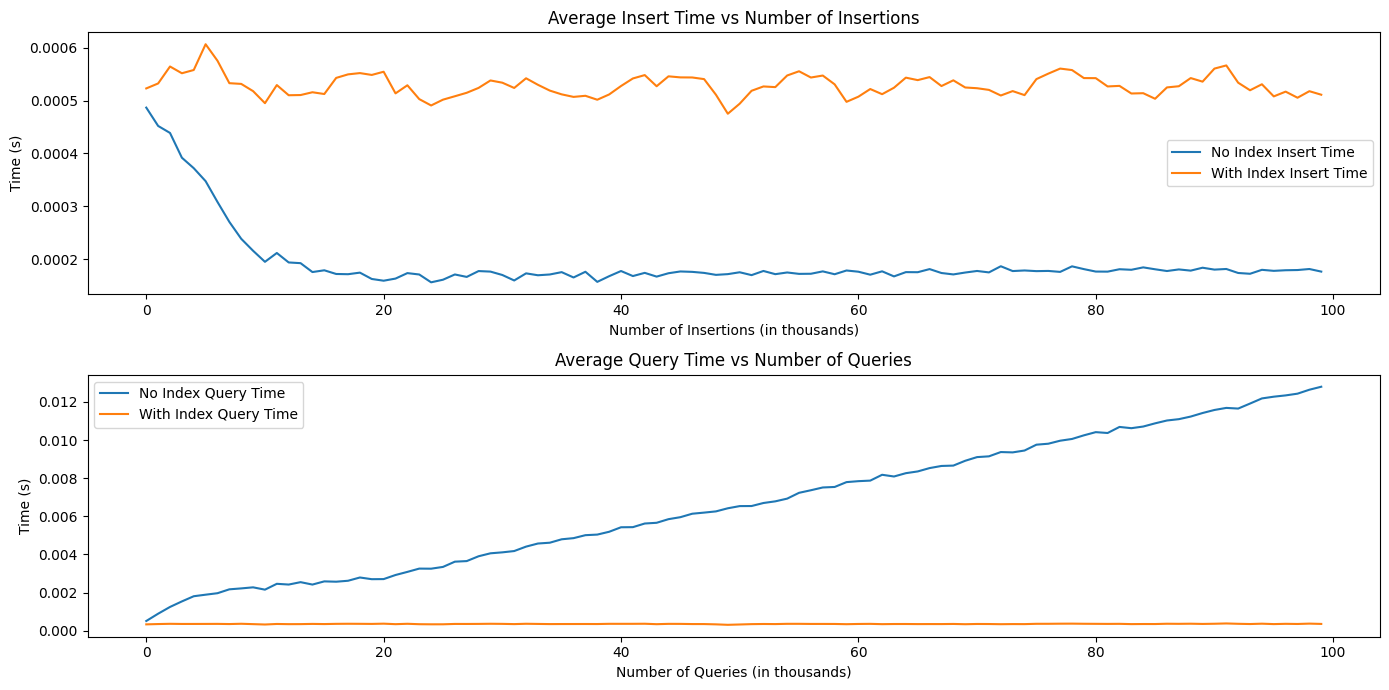

In [5]:
data = {
    'insert_times_no_index': insert_times['passengers_no_index'],
    'insert_times_with_index': insert_times['passengers_with_index'],
    'query_times_no_index': query_times['passengers_no_index'],
    'query_times_with_index': query_times['passengers_with_index']
}
df = pd.DataFrame(data)
df.to_csv('performance_times.csv', index=True)

def get_average_per_n(data, n):
    return [np.mean(data[i:i + n]) for i in range(0, len(data), n)]

avg_insert_times_no_index = get_average_per_n(insert_times['passengers_no_index'], 1000)
avg_insert_times_with_index = get_average_per_n(insert_times['passengers_with_index'], 1000)
avg_query_times_no_index = get_average_per_n(query_times['passengers_no_index'], 1000)
avg_query_times_with_index = get_average_per_n(query_times['passengers_with_index'], 1000)

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(range(len(avg_insert_times_no_index)), avg_insert_times_no_index, label='No Index Insert Time')
plt.plot(range(len(avg_insert_times_with_index)), avg_insert_times_with_index, label='With Index Insert Time')
plt.xlabel('Number of Insertions (in thousands)')
plt.ylabel('Time (s)')
plt.title('Average Insert Time vs Number of Insertions')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(len(avg_query_times_no_index)), avg_query_times_no_index, label='No Index Query Time')
plt.plot(range(len(avg_query_times_with_index)), avg_query_times_with_index, label='With Index Query Time')
plt.xlabel('Number of Queries (in thousands)')
plt.ylabel('Time (s)')
plt.title('Average Query Time vs Number of Queries')
plt.legend()

plt.tight_layout()
plt.show()